In [2]:

import tensorflow as tf
import numpy as np
###
import sys
import os
sys.path.append("c:\\Users\\nikos\\Documents\\GitHub\\Movie_Review_Classifier\\Raw data processing")
from loadData import *
from createVocabulary import *
###

In [6]:
xTrain, yTrain = loadTrainData()
xTest, yTest = loadTestData()

VOCAB_SIZE = 10000
SEQ_MAX_LENGTH = 150
vectorizer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, 
                                               output_mode='int', 
                                               ngrams=1, name='vector_text',
                                               output_sequence_length=SEQ_MAX_LENGTH)
with tf.device('/CPU:0'):
  vectorizer.adapt(xTrain)

In [4]:
import fasttext


fasttext_model = fasttext.load_model('cc.en.300.bin')
embedding_matrix = np.zeros(shape=(len(vectorizer.get_vocabulary()), 300))

print(type(vectorizer.get_vocabulary()))
for i, word in enumerate(vectorizer.get_vocabulary()):
  embedding_matrix[i] = fasttext_model.get_word_vector(word=word)

del fasttext_model

<class 'list'>


In [5]:
def get_fasttext_bigru(num_layers=1, h_size=64):
  inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='txt_input')
  x = vectorizer(inputs)
  x = tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()),
                                output_dim=300, name='word_embeddings',
                                trainable=False, weights=[embedding_matrix],
                                mask_zero=True)(x)

  # x = tf.keras.layers.Dense(units=h_size, activation='relu', name='dense')(x)
  x = tf.keras.layers.Dropout(rate=0.5)(x)

  for n in range(num_layers):
    if n != num_layers - 1:
      x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=h_size, 
                              name=f'bigru_cell_{n}', 
                              return_sequences=True,
                              dropout=0.2))(x)
    else:
      x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=h_size, 
                                        name=f'bigru_cell_{n}',
                                        dropout=0.2))(x)

  x = tf.keras.layers.Dropout(rate=0.5)(x)
  o = tf.keras.layers.Dense(units=1, activation='sigmoid', name='lr')(x)
  return tf.keras.models.Model(inputs=inputs, outputs=o, name='simple_rnn')

imdb_fasttext_bigru = get_fasttext_bigru()
print(imdb_fasttext_bigru.summary())

Model: "simple_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 txt_input (InputLayer)      [(None, 1)]               0         
                                                                 
 vector_text (TextVectoriza  (None, 150)               0         
 tion)                                                           
                                                                 
 word_embeddings (Embedding  (None, 150, 300)          3000000   
 )                                                               
                                                                 
 dropout (Dropout)           (None, 150, 300)          0         
                                                                 
 bidirectional (Bidirection  (None, 128)               140544    
 al)                                                             
                                                        

In [101]:
imdb_fasttext_bigru.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['binary_accuracy'])

print(len(vectorizer.get_vocabulary()))

xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
rnn_history = imdb_fasttext_bigru.fit(x=xTrain, y=yTrain,
                        epochs=20, verbose=1, validation_split = 0.2)

10000
Epoch 1/20
625/625 [==============================] - 46s 66ms/step - loss: 0.6278 - binary_accuracy: 0.6411 - val_loss: 0.5079 - val_binary_accuracy: 0.7634
Epoch 2/20
625/625 [==============================] - 43s 68ms/step - loss: 0.4906 - binary_accuracy: 0.7661 - val_loss: 0.4393 - val_binary_accuracy: 0.7984
Epoch 3/20
625/625 [==============================] - 43s 69ms/step - loss: 0.4483 - binary_accuracy: 0.7910 - val_loss: 0.3933 - val_binary_accuracy: 0.8222
Epoch 4/20
625/625 [==============================] - 43s 68ms/step - loss: 0.4227 - binary_accuracy: 0.8044 - val_loss: 0.3862 - val_binary_accuracy: 0.8264
Epoch 5/20
625/625 [==============================] - 44s 70ms/step - loss: 0.4070 - binary_accuracy: 0.8159 - val_loss: 0.3752 - val_binary_accuracy: 0.8366
Epoch 6/20
625/625 [==============================] - 42s 67ms/step - loss: 0.3946 - binary_accuracy: 0.8207 - val_loss: 0.3626 - val_binary_accuracy: 0.8394
Epoch 7/20
625/625 [==========================

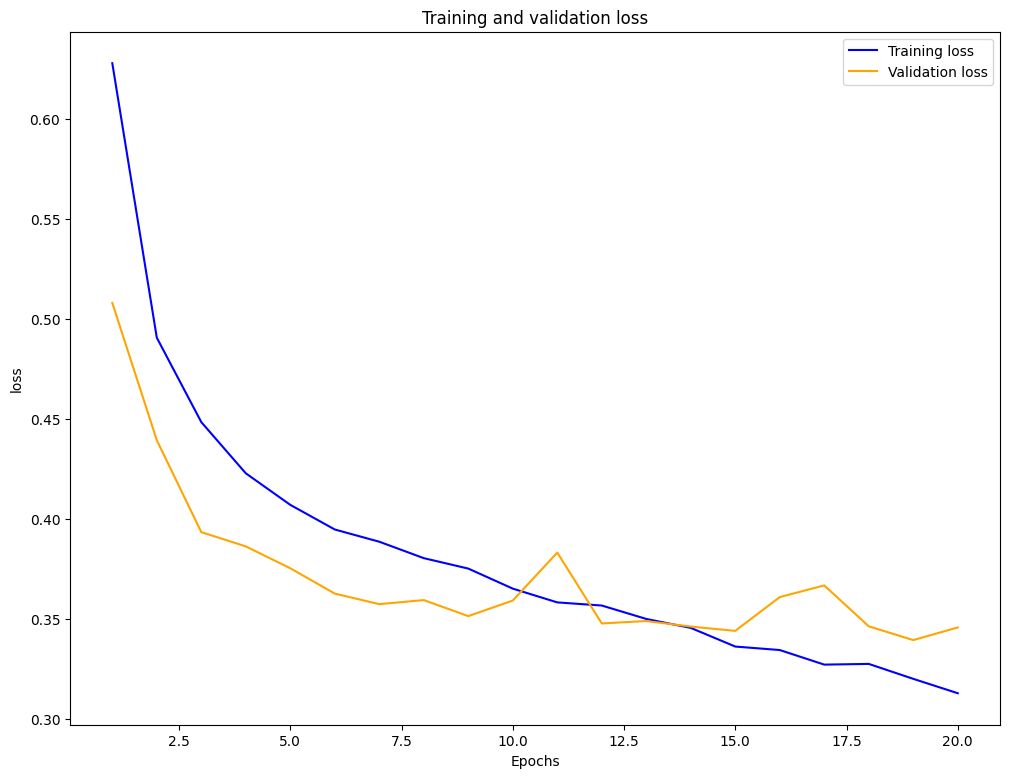

In [102]:
import matplotlib.pyplot as plt

def plot(his, kind):
  train = his.history[kind]
  val = his.history['val_' + kind]
  epochs = range(1, len(train)+1)
  plt.figure(figsize=(12,9))
  plt.plot(epochs, train, 'b', label='Training ' + kind)
  plt.plot(epochs, val, 'orange', label='Validation ' + kind)
  plt.title('Training and validation ' + kind)
  plt.xlabel('Epochs')
  plt.ylabel(kind)
  # x1, x2, y1, y2 = plt.axis()
  # plt.axis((x1, x2, 0, 0.2))
  plt.legend()
  plt.show()

plot(rnn_history, 'loss')

<class 'numpy.ndarray'>
-------------------
Epoch 1/5
157/157 [==============================] - 15s 63ms/step - loss: 0.6903 - binary_accuracy: 0.5402
Epoch 2/5
157/157 [==============================] - 10s 66ms/step - loss: 0.6628 - binary_accuracy: 0.6122
Epoch 3/5
157/157 [==============================] - 10s 65ms/step - loss: 0.6408 - binary_accuracy: 0.6412
Epoch 4/5
157/157 [==============================] - 10s 64ms/step - loss: 0.5986 - binary_accuracy: 0.6724
Epoch 5/5
782/782 [==============================] - 16s 21ms/step
Epoch 1/5
313/313 [==============================] - 22s 70ms/step - loss: 0.4986 - binary_accuracy: 0.7597
Epoch 2/5
313/313 [==============================] - 22s 70ms/step - loss: 0.4700 - binary_accuracy: 0.7759
Epoch 3/5
313/313 [==============================] - 22s 70ms/step - loss: 0.4534 - binary_accuracy: 0.7857
Epoch 4/5
313/313 [==============================] - 22s 70ms/step - loss: 0.4296 - binary_accuracy: 0.8014
Epoch 5/5
313/313 [======

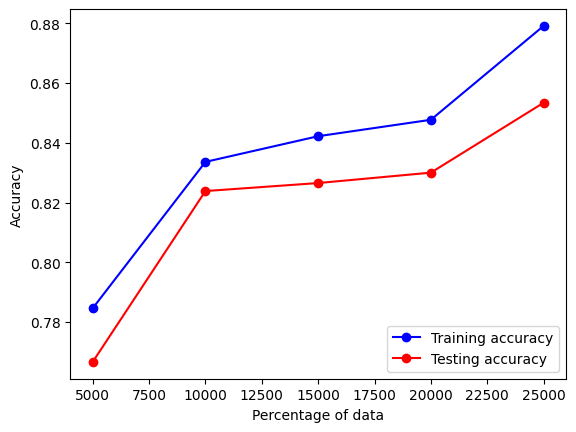

In [104]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


def custom_learning_curve(x_train, y_train,
                           x_test, y_test,
                          n_splits):

  
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  x_test = np.array(x_test)
  y_test = np.array(y_test)
  split_size = int(len(x_train) / n_splits)
  print(type(x_train))
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)
  print("-------------------")
  train_accuracies = list()
  val_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  #print(curr_x.shape)
  curr_y = y_splits[0]
  #print(curr_y.shape)

  imdb_fasttext_bigru = get_fasttext_bigru()

  imdb_fasttext_bigru.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['binary_accuracy'])
  imdb_fasttext_bigru.fit(x=curr_x, y=curr_y,
                        epochs=5, verbose=1)
  
  predictions = imdb_fasttext_bigru.predict(curr_x)
  predictions = (predictions > 0.5).astype(int)
  train_accuracies.append(accuracy_score(curr_y,
                                         predictions))

  #val_accuracies.append(accuracy_score(y_val, nb.predict(x_val)))
  predictions = imdb_fasttext_bigru.predict(x_test)
  predictions = (predictions > 0.5).astype(int)
  test_accuracies.append(accuracy_score(y_test, predictions))

  for i in range(1, len(x_splits)):
    
    
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    #print(curr_x.shape)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    #print(curr_y.shape)
    imdb_fasttext_bigru.fit(x=curr_x, y=curr_y,
                        epochs=5, verbose=1)

    predictions = imdb_fasttext_bigru.predict(curr_x)
    predictions = (predictions > 0.5).astype(int)
    train_accuracies.append(accuracy_score(curr_y,
                                         predictions))
    
    print(train_accuracies[i])

    #val_accuracies.append(accuracy_score(y_val, nb.predict(x_val)))
    predictions = imdb_fasttext_bigru.predict(x_test)
    predictions = (predictions > 0.5).astype(int)
    acc = accuracy_score(y_test, predictions)
    print(acc)
    test_accuracies.append(acc)

  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), train_accuracies, 'o-', color="b",
             label="Training accuracy")
  
  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), test_accuracies, 'o-', color="red",
           label="Testing accuracy")
  plt.legend(loc="lower right")
  plt.xlabel('Percentage of data')
  plt.ylabel('Accuracy')
  plt.show()




xTest, yTest = shuffleData(xTest, yTest)
xTrain, yTrain = shuffleData(xTrain, yTrain)


custom_learning_curve(xTrain, yTrain, xTest, yTest, 5)



Epoch 1/5

157/157 [==============================] - 15s 60ms/step - loss: 0.6919 - binary_accuracy: 0.5320
Epoch 2/5
157/157 [==============================] - 11s 67ms/step - loss: 0.6441 - binary_accuracy: 0.6252
Epoch 3/5
157/157 [==============================] - 11s 69ms/step - loss: 0.6066 - binary_accuracy: 0.6780
Epoch 4/5
157/157 [==============================] - 11s 68ms/step - loss: 0.5330 - binary_accuracy: 0.7312
Epoch 5/5
782/782 [==============================] - 17s 19ms/step
Epoch 1/5
313/313 [==============================] - 18s 59ms/step - loss: 0.4869 - binary_accuracy: 0.7687
Epoch 2/5
313/313 [==============================] - 20s 64ms/step - loss: 0.4600 - binary_accuracy: 0.7857
Epoch 3/5
313/313 [==============================] - 20s 64ms/step - loss: 0.4456 - binary_accuracy: 0.7930
Epoch 4/5
313/313 [==============================] - 20s 63ms/step - loss: 0.4279 - binary_accuracy: 0.8103
Epoch 5/5
782/782 [==============================] - 15s 19ms/step
E

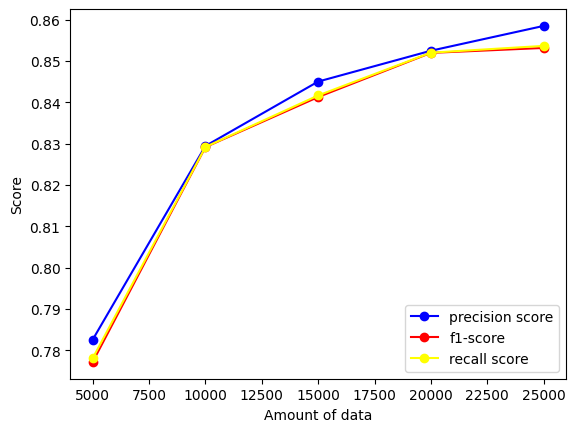

782/782 [==============================] - 19s 24ms/step
              precision    recall  f1-score   support

           0       0.90      0.80      0.84     12500
           1       0.82      0.91      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.86      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000



In [7]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


imdb_fasttext_bigru = get_fasttext_bigru()


xTrain, yTrain = shuffleData(xTrain, yTrain)
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
classifications = []
split_size = int(len(xTrain) / 5)
x_splits = np.split(np.array(xTrain), 5) # must be equal division
y_splits = np.split(np.array(yTrain), 5)
curr_x = x_splits[0]
curr_y = y_splits[0]

imdb_fasttext_bigru.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['binary_accuracy'])
imdb_fasttext_bigru.fit(x=curr_x, y=curr_y,
                        epochs=5, verbose=1)
predictions = imdb_fasttext_bigru.predict(xTest)
predictions = (predictions > 0.5).astype(int)

classifications.append(classification_report(yTest, predictions, output_dict=True))

for i in range(1,5):

    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)

    imdb_fasttext_bigru.fit(x=curr_x, y=curr_y,
                        epochs=5, verbose=1)
    predictions = imdb_fasttext_bigru.predict(xTest)
    predictions = (predictions > 0.5).astype(int)

    classifications.append(classification_report(yTest, predictions, output_dict=True ))

precisions = []
f1 = []
recall = []
for i in classifications:
    precisions.append((i["0"]["precision"] + i["1"]["precision"])/2 )
    f1.append((i["0"]["f1-score"] + i["1"]["f1-score"])/2 )
    recall.append((i["0"]["recall"] + i["1"]["recall"])/2 )
    




plt.plot(list(range(split_size, len(xTrain) + split_size,
                    split_size)), precisions, 'o-', color="b",
            label="precision score")

plt.plot(list(range(split_size, len(xTrain) + split_size,
                    split_size)), f1, 'o-', color="red",
            label="f1-score")

plt.plot(list(range(split_size, len(xTrain) + split_size,
                    split_size)), recall, 'o-', color="yellow",
            label="recall score")

plt.legend(loc="lower right")
plt.xlabel('Amount of data')
plt.ylabel('Score')
plt.show()


predictions = imdb_fasttext_bigru.predict(xTest)
predictions = (predictions > 0.5).astype(int)

print(classification_report(yTest, predictions, output_dict=False))